[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 84096, number of used features: 4
[LightGBM] [Info] Start training from score 23.859394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 15.1899
Root Mean Squared Error (RMSE): 15.189919633723044
Mean Absolute Error (MAE): 10.479850535578153


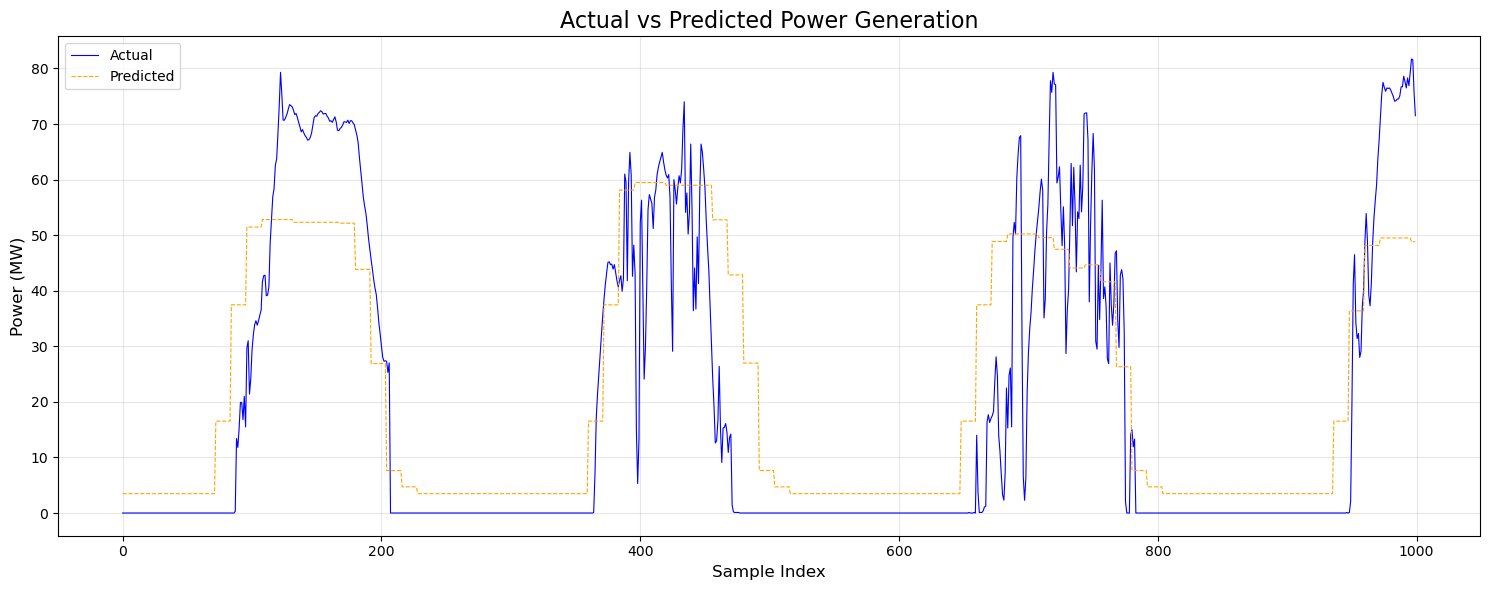

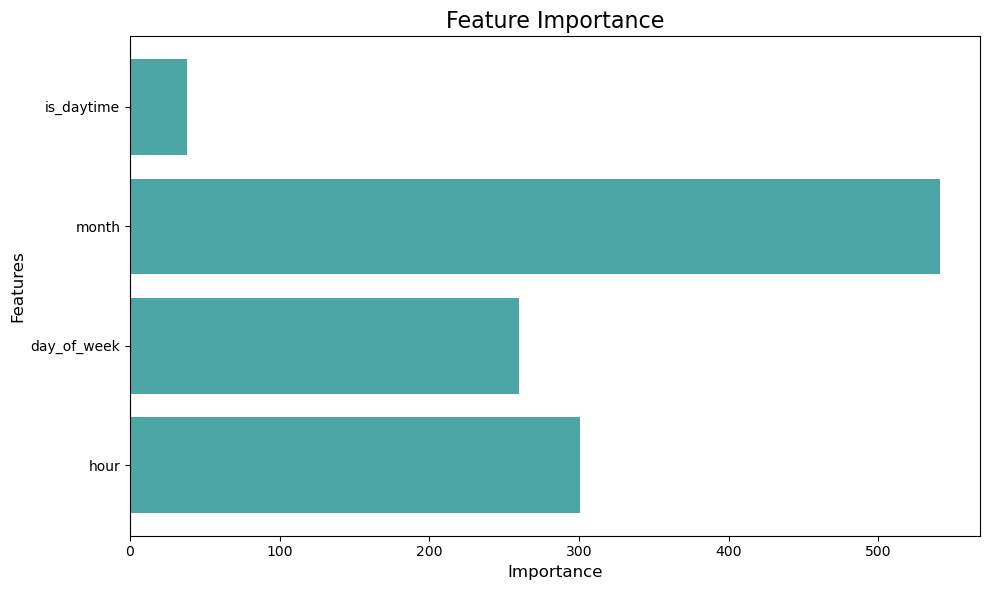

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
file_path = "ms-pv-2006/Actual_30.25_-89.45_2006_UPV_118MW_5_Min.csv"
data = pd.read_csv(file_path)
data['LocalTime'] = pd.to_datetime(data['LocalTime'], format='%m/%d/%y %H:%M')

# Feature Engineering
data['hour'] = data['LocalTime'].dt.hour
data['day_of_week'] = data['LocalTime'].dt.dayofweek
data['month'] = data['LocalTime'].dt.month
data['is_daytime'] = ((data['hour'] >= 6) & (data['hour'] <= 18)).astype(int)

# Define features and target variable
X = data[['hour', 'day_of_week', 'month', 'is_daytime']]
y = data['Power(MW)']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# LightGBM Model Training
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model with early stopping
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],  # Validation set
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Early stopping callback
        lgb.log_evaluation(period=100)          # Log evaluation progress every 100 iterations
    ]
)

# Predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:1000], label="Actual", color='blue', linewidth=0.8)
plt.plot(y_pred[:1000], label="Predicted", color='orange', linestyle='--', linewidth=0.8)
plt.title('Actual vs Predicted Power Generation', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Power (MW)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance
importance = model.feature_importance()
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance, color='teal', alpha=0.7)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()
